In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
keras = tf.keras

import datetime

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [2]:
def trend(time, slope=0):
    return slope * time

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [3]:

# for CNN, LSTM,
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

#for RNN
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset




In [4]:
df= pd.read_csv('../../datasets/otomoto_daily_income.csv')

In [5]:
df = df[890:].reset_index()

In [6]:

df['date'] = df['date'].apply(lambda x: datetime.date(int(x.split('/')[0]),int(x.split('/')[1]),int(x.split('/')[2])))

In [7]:
start_date = datetime.date(2015,1,1)
date_list = []
income_list = []
current = start_date
while current < datetime.date.today():

    date_list.append(current)
    if df[df['date']==current]['Unnamed: 1'].shape[0]>0:
        income_list.append(df[df['date']==current]['Unnamed: 1'].max())
    else:
        income_list.append(0)


    current += datetime.timedelta(days=1)





In [9]:
test_df = pd.DataFrame()
test_df['data'] = date_list
test_df['income'] = income_list
test_df['income'].fillna(0,inplace=True)

In [10]:
test_df['week'] = test_df['data'].apply(lambda x: x.isocalendar()[1])
test_df['year'] =test_df['data'].apply(lambda x: x.isocalendar()[0])
test_df['month'] =test_df['data'].apply(lambda x: x.month)

In [166]:
groupped = test_df.groupby(['year','month'])['income'].sum().reset_index()

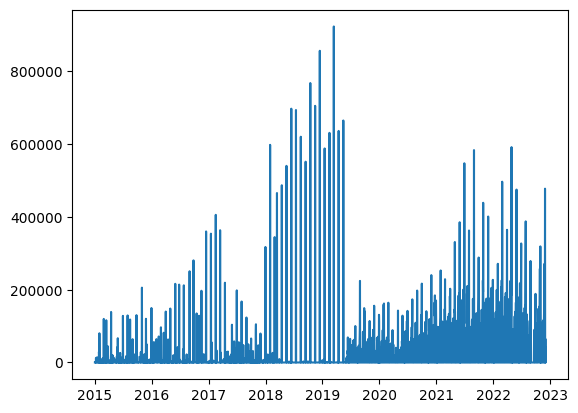

In [116]:
plt.plot(date_list,income_list)

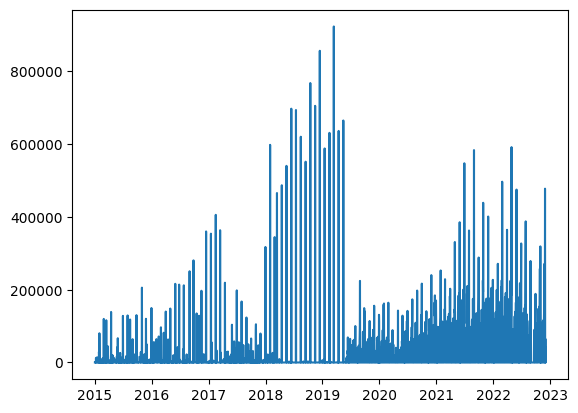

In [117]:
plt.plot(date_list,income_list)

In [64]:
test_df['income'].describe()

count      2896.000000
mean      31623.686029
std       74057.692778
min           0.000000
25%           0.000000
50%           0.000000
75%       35447.545000
max      923598.480000
Name: income, dtype: float64

In [171]:
groupped[-12:]

,year,month,income
84,2022,1,2023374.27
85,2022,2,2532464.08
86,2022,3,2720704.89
87,2022,4,2728413.42
88,2022,5,2221000.61
89,2022,6,2640644.66
90,2022,7,2616073.61
91,2022,8,1436102.03
92,2022,9,886355.45
93,2022,10,2137349.75


In [11]:
time = date_list
series = np.array(test_df['income'])
split_time = 2557
# split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=32)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=32)


In [16]:
np.percentile(test_df['income'],99)

362749.76

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 350000)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\sebas\anaconda3\envs\tensorflow_1\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


20/20 [==============================] - 3s 56ms/step - loss: 40152.6484 - mae: 40153.1484 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 0s 14ms/step - loss: 31443.4316 - mae: 31443.9316 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 28087.5039 - mae: 28088.0000 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 0s 12ms/step - loss: 28090.3301 - mae: 28090.8320 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 27128.1582 - mae: 27128.6562 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 26679.6367 - mae: 26680.1367 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 26209.2852 - mae: 26209.7871 - lr: 1.9953e-08
Epoch 8/100
20/20 [==============================] - 0s 9ms/step - loss: 25818.9531 - mae: 25819.4512 - lr: 2.2387e-08
Epoch 9/100
20/20 [==============================] - 0s 

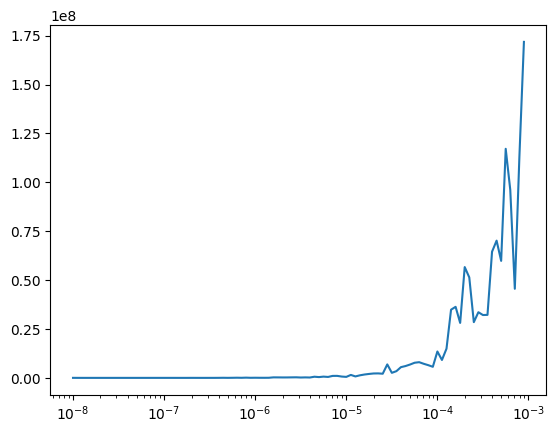

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 100000)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
20/20 [==============================] - 3s 56ms/step - loss: 32195.5742 - mae: 32196.0742 - val_loss: 70973.4688 - val_mae: 70973.9688
Epoch 2/500
20/20 [==============================] - 0s 18ms/step - loss: 27059.5430 - mae: 27060.0449 - val_loss: 65935.6094 - val_mae: 65936.1094
Epoch 3/500
20/20 [==============================] - 0s 14ms/step - loss: 27722.8438 - mae: 27723.3438 - val_loss: 67215.5781 - val_mae: 67216.0781
Epoch 4/500
20/20 [==============================] - 0s 14ms/step - loss: 27186.8516 - mae: 27187.3535 - val_loss: 68062.2656 - val_mae: 68062.7734
Epoch 5/500
20/20 [==============================] - 0s 13ms/step - loss: 27103.5820 - mae: 27104.0840 - val_loss: 66017.2500 - val_mae: 66017.7500
Epoch 6/500
20/20 [==============================] - 0s 10ms/step - loss: 27154.9668 - mae: 27155.4668 - val_loss: 67369.7578 - val_mae: 67370.2500
Epoch 7/500
20/20 [==============================] - 0s 12ms/step - loss: 25638.3477 - mae: 25638.8457 - val_los

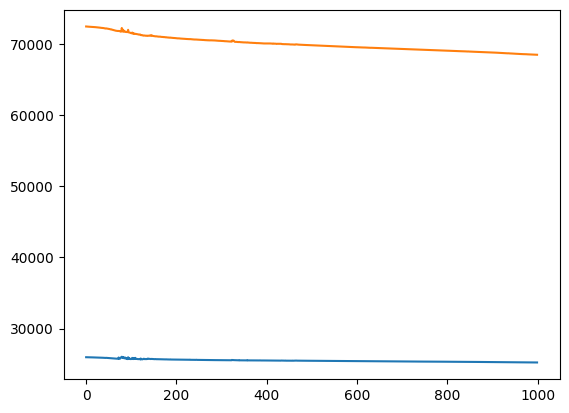

In [80]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 250000)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100


C:\Users\sebas\anaconda3\envs\tensorflow_1\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


20/20 [==============================] - 3s 80ms/step - loss: 26548.1211 - mae: 26548.6191 - lr: 1.0000e-07
Epoch 2/100
20/20 [==============================] - 2s 71ms/step - loss: 26542.3965 - mae: 26542.8965 - lr: 1.1220e-07
Epoch 3/100
20/20 [==============================] - 2s 72ms/step - loss: 26535.3594 - mae: 26535.8574 - lr: 1.2589e-07
Epoch 4/100
20/20 [==============================] - 2s 72ms/step - loss: 26527.5312 - mae: 26528.0293 - lr: 1.4125e-07
Epoch 5/100
20/20 [==============================] - 2s 73ms/step - loss: 26519.0781 - mae: 26519.5781 - lr: 1.5849e-07
Epoch 6/100
20/20 [==============================] - 2s 72ms/step - loss: 26510.0273 - mae: 26510.5195 - lr: 1.7783e-07
Epoch 7/100
20/20 [==============================] - 1s 70ms/step - loss: 26502.1621 - mae: 26502.6543 - lr: 1.9953e-07
Epoch 8/100
20/20 [==============================] - 1s 67ms/step - loss: 26495.8516 - mae: 26496.3398 - lr: 2.2387e-07
Epoch 9/100
20/20 [==============================] -

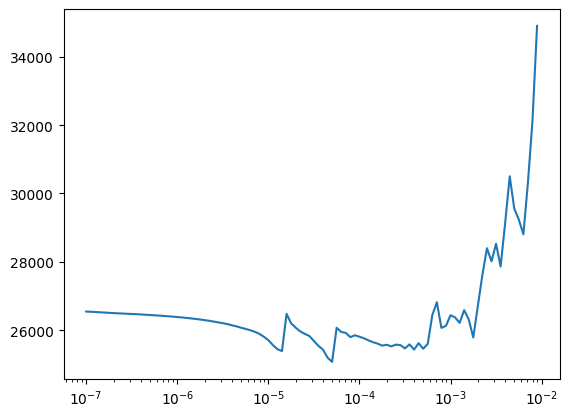

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-7, 1e-4, 0, 30])

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                      batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100


InvalidArgumentError: Graph execution error:

Invalid input_h shape: [1,1,100] [1,32,100]
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_274668]